In [25]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
import itertools
import os

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


In [26]:
device = torch.device("cuda")

In [27]:
labels = [item for item in os.listdir("data/kth_dataset") if os.path.isdir(os.path.join("data/kth_dataset", item))]


In [28]:
data_dict = np.load("data\kth_dataset\processed_data.npz")
combined_data = []
combined_labels = []

# Loop through the dictionary to combine data and labels
for label, data_array in data_dict.items():
    # Append the data array entries to all_data
    combined_data.append(data_array)  # Keeps the (num_entries, 4, width, height) shape
    # Create a list of labels for each entry in this data_array and extend all_labels
    combined_labels.extend([label] * data_array.shape[0])

del(data_array)
# Concatenate all data along the first axis to create a single numpy array
combined_data = np.concatenate(combined_data, axis=0)  # Shape: (total_entries, 4, width, height)
combined_labels = np.array(combined_labels)             # Shape: (total_entries,)


# Convert each label in combined_labels to its corresponding index
label_indices = [labels.index(label) for label in combined_labels]

# Create a one-hot encoded array using np.eye
num_classes = len(labels)
one_hot_labels = np.eye(num_classes)[label_indices]  # Shape: (total_entries, num_classes)




indices = np.random.permutation(combined_data.shape[0])
shuffled_data = combined_data[indices]
shuffled_labels = one_hot_labels[indices]
del(combined_data, combined_labels, one_hot_labels, data_dict, label_indices, indices)

print("Combined data shape:", shuffled_data.shape)
print("Combined labels shape:", shuffled_labels.shape)

Combined data shape: (75854, 30, 40)
Combined labels shape: (75854, 6)


In [29]:
# Define the split ratios
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15

# Total number of entries
total_entries = shuffled_data.shape[0]

# Calculate split indices
train_end = int(total_entries * train_ratio)
val_end = train_end + int(total_entries * val_ratio)

# Split the data and labels
train_data = shuffled_data[:train_end]
train_labels = shuffled_labels[:train_end]

val_data = shuffled_data[train_end:val_end]
val_labels = shuffled_labels[train_end:val_end]

test_data = shuffled_data[val_end:]
test_labels = shuffled_labels[val_end:]

del(shuffled_data, shuffled_labels)

# Print shapes to verify
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


Train data shape: (56890, 30, 40)
Train labels shape: (56890, 6)
Validation data shape: (7585, 30, 40)
Validation labels shape: (7585, 6)
Test data shape: (11379, 30, 40)
Test labels shape: (11379, 6)


In [30]:
# Dictionary of all the rows of each mask-set in every file 
json_data = {
    "365nm":{
        "I1":range(0, 5),
        "I2":range(10, 15),
        "I3":range(18, 23),
        "I4":range(25, 30)
    },
    "455nm":{
        "I1":range(0, 5),
        "I2":range(7, 12),
        "I3":range(14, 19),
        "I4":range(21, 26)
    },
    "White":{
        "I1":range(0, 5),
        "I2":range(9, 14),
        "I3":range(16, 21),
        "I4":range(24, 29)
    }
}

In [31]:
combined_tables = []
for filename in ["White", "365nm", "455nm"]:
    path = "data/"+filename+".xlsx" 
    df = pd.read_excel(path, usecols='B:Q') # Read the excel sheet
    tables = [df.iloc[json_data[filename][key]].copy().reset_index(drop=True) for key in list(json_data[filename].keys())]
    combined_table = pd.concat(tables, axis=0)
    # combined_tables.append(combined_table)
    combined_tables.append(tables)
    del(df, tables, combined_table)

combined_tables[1] = [combined_tables[1][i].reindex(columns=combined_tables[0][0].columns) for i in range(4)]

In [32]:
NUMBER_OF_MASKS = 3
colour_indices = np.array([0, 1, 2])    # Three colours 365nm, 455 nm, White 
intensity_indices = np.array([0, 1, 2, 3])    # I1, I2, I3, I4
voltage_indices = np.array([4])    # rows in each of I1 to I4


# Generate a meshgrid of all combinations so that we don't sample the same triplet twice
colour_masks, intensity_masks, voltage_masks = np.meshgrid(
    colour_indices, intensity_indices, voltage_indices, indexing='ij'
)

# Flatten the arrays and stack them into an (N,3) array of unique 3D points
all_triplets = np.column_stack((colour_masks.ravel(), intensity_masks.ravel(), voltage_masks.ravel()))

# Randomly select unique 3D points
unique_indices = np.random.choice(all_triplets.shape[0], size=NUMBER_OF_MASKS, replace=False)
selected_triplets = all_triplets[unique_indices]

# Extract the selected masks
colour_masks = selected_triplets[:, 0]
intensity_masks = selected_triplets[:, 1]
voltage_masks = selected_triplets[:, 2]

# Uncomment to override

# colour_masks = np.array([1, 1, 1, 2, 2, 2, 1, 2])
# intensity_masks = np.array([1, 3, 2, 1, 2, 3, 1, 0])
# voltage_masks = np.array([4, 4, 4, 4, 4, 4, 3, 4])

colour_masks = np.array([1, 0, 2 ])
intensity_masks = np.array([3, 3, 3])
voltage_masks = np.array([4, 4, 4])
NUMBER_OF_MASKS = (len(colour_masks) == len(intensity_masks)) * len(colour_masks)

number_of_devices = 30 * 40 // 1
print("Selected Colour Masks:", colour_masks)
print("Selected Intensity Masks:", intensity_masks)
print("Selected Voltage Masks:", voltage_masks)

Selected Colour Masks: [1 0 2]
Selected Intensity Masks: [3 3 3]
Selected Voltage Masks: [4 4 4]


In [33]:
class CustomDataset(Dataset):
    def __init__(self, dataset:np.array,
                 labels:np.array,
                 combined_tables:list[pd.DataFrame],
                 colour_masks:np.array, 
                 intensity_masks:np.array, 
                 voltage_masks:np.array
                 ):
        self.processed_data = []
        self.labels = []
        

        for colour_mask, intensity_mask, voltage_mask in zip(colour_masks, intensity_masks, voltage_masks):
            mapping_dict = combined_tables[colour_mask][intensity_mask].loc[voltage_mask].to_dict()
            reservoir_output = np.vectorize(mapping_dict.get)(dataset)
            self.processed_data.append(reservoir_output)

        self.processed_data = np.concatenate(self.processed_data, axis=1) * 1e9
        # for i in range(len(colour_masks)):
        #     self.processed_data[:, i:i+30, :] = (self.processed_data[:, i:i+30, :] - self.processed_data[:, i:i+30, :].mean()) / (self.processed_data[:, i:i+30, :].std() + 1e-6)
        
        self.processed_data = self.processed_data.reshape((self.processed_data.shape[0], -1))

        self.labels = torch.tensor(labels, device=device).argmax(dim=1)
        self.processed_data = torch.tensor(self.processed_data, device=device)

    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]
    

In [34]:
class ReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 6)
        self.activation = nn.functional.leaky_relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x

In [35]:
print(f"Memory taken: {train_data.nbytes / (1024**3):.4f} GB")


Memory taken: 0.5086 GB


In [36]:

BATCH_SIZE = 1024


train_dataset = CustomDataset(train_data, train_labels, combined_tables, colour_masks, intensity_masks, voltage_masks)
test_dataset = CustomDataset(test_data, test_labels, combined_tables, colour_masks, intensity_masks, voltage_masks)


train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



In [37]:
print(f"Memory taken: {train_dataset.processed_data.nbytes / (1024**3):.4f} GB")

Memory taken: 1.5259 GB


In [38]:
num_classes = train_dataset.labels.max().item() + 1  # Get the number of classes
unique_labels, class_counts = torch.unique(train_dataset.labels, return_counts=True)
print(class_counts)
# Step 2: Compute class weights (inverse frequency)
class_weights = torch.zeros(train_dataset.labels.max().item() + 1, dtype=torch.float32).to(device) 
class_weights[unique_labels] = 1.0 / class_counts.float()  # Assign inverse frequency

# Normalize (optional)
class_weights = class_weights / class_weights.sum()
print(class_weights)

tensor([10807, 10546, 12843,  6822,  4925, 10947], device='cuda:0')
tensor([0.1310, 0.1343, 0.1103, 0.2076, 0.2875, 0.1294], device='cuda:0')


In [39]:
train_dataset.labels.unique()

tensor([0, 1, 2, 3, 4, 5], device='cuda:0')

In [40]:

EPOCHS = 3000
learning_rate = 0.0005
# learning_rate = 1e-3

model = ReadoutLayer(number_of_devices*NUMBER_OF_MASKS).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=6).to(device)
precision = Precision(task="multiclass", num_classes=6, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=6, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=6, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=6).to(device)


In [41]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [1/3000], Loss: 1.2520 Validation - Accuracy: 0.5410 Precision: 0.3708  Recall: 0.4536 F1 Score: 0.4023
Epoch [2/3000], Loss: 1.2368 Validation - Accuracy: 0.5548 Precision: 0.4395  Recall: 0.4667 F1 Score: 0.4293
Epoch [3/3000], Loss: 1.1225 Validation - Accuracy: 0.5703 Precision: 0.4774  Recall: 0.4829 F1 Score: 0.4480
Epoch [4/3000], Loss: 1.0401 Validation - Accuracy: 0.5622 Precision: 0.4957  Recall: 0.4907 F1 Score: 0.4813
Epoch [5/3000], Loss: 1.0430 Validation - Accuracy: 0.5664 Precision: 0.5032  Recall: 0.4928 F1 Score: 0.4713
Epoch [6/3000], Loss: 1.0799 Validation - Accuracy: 0.5887 Precision: 0.5275  Recall: 0.5024 F1 Score: 0.4693
Epoch [7/3000], Loss: 1.0154 Validation - Accuracy: 0.5805 Precision: 0.5162  Recall: 0.5110 F1 Score: 0.4964
Epoch [8/3000], Loss: 1.0174 Validation - Accuracy: 0.5864 Precision: 0.5294  Recall: 0.5091 F1 Score: 0.5000
Epoch [9/3000], Loss: 1.0070 Validation - Accuracy: 0.5895 Precision: 0.5296  Recall: 0.5118 F1 Score: 0.4965
Epoch [10/

In [42]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')

        

C:\Users\adith\AppData\Local\Temp\ipykernel_22076\2274749388.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 73.62%
Test Precision: 71.0917%
Test Recall: 69.1459%
Test F1 Score: 0.6957


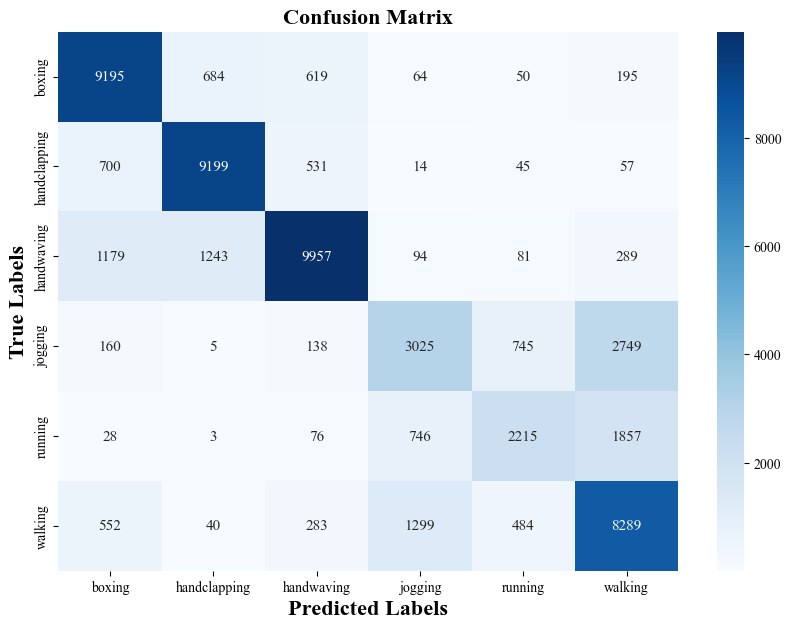

In [43]:
import seaborn as sns
label_names = [item for item in os.listdir("data/kth_dataset") if os.path.isdir(os.path.join("data/kth_dataset", item))]
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix.cpu(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, 
            yticklabels=label_names,
            annot_kws={"size": 11, "family": "Times New Roman"})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.show()

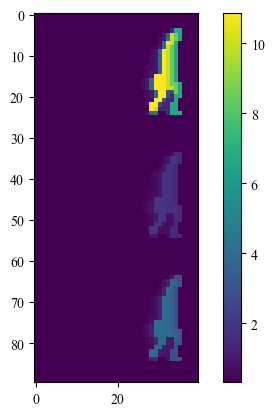

jogging


In [44]:
idx = 400
plt.imshow(train_dataset.processed_data[idx].reshape((-1, 40)).cpu().numpy())
plt.colorbar()
plt.show()
print(label_names[train_dataset.labels[idx]])

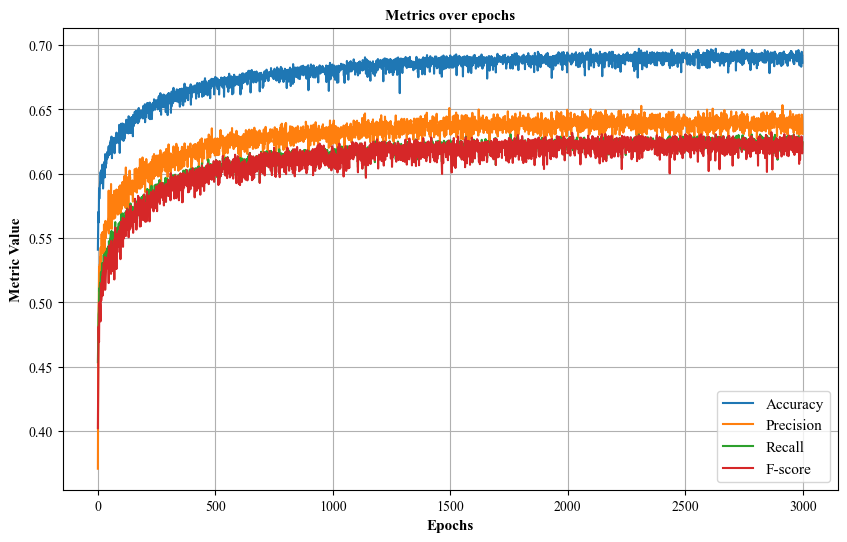

In [45]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [46]:
all_labels.unique()

tensor([0, 1, 2, 3, 4, 5], device='cuda:0')

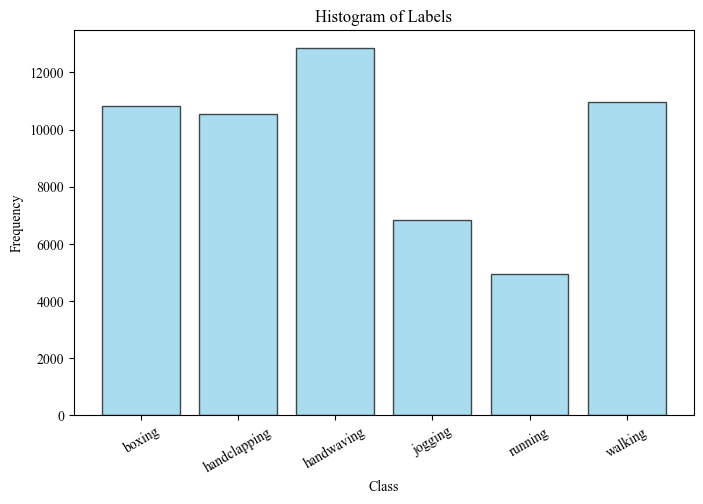

In [47]:

# # Plot histogram
# plt.figure(figsize=(8, 5))
# plt.hist(all_labels.cpu().numpy(), bins=6, edgecolor='black', alpha=0.7)

# Compute histogram counts
num_classes = len(label_names)
counts, bins = np.histogram(all_labels.cpu(), bins=np.arange(num_classes + 1) - 0.5)  # Center bars on integers

plt.figure(figsize=(8, 5))
plt.bar(label_names, counts, color='skyblue', edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Histogram of Labels")

# Rotate x-axis labels if needed
plt.xticks(rotation=30)  

# Show the plot
plt.show()
# # Labels and title
# plt.xlabel("Label")
# plt.ylabel("Frequency")
# plt.title("Histogram of Labels")
# plt.xticks(range(all_labels.cpu().min(), all_labels.cpu().max() + 1))  # Ensure all labels are shown

# # Show the plot
# plt.show()

In [48]:
test_confusion_matrix

tensor([[9195,  684,  619,   64,   50,  195],
        [ 700, 9199,  531,   14,   45,   57],
        [1179, 1243, 9957,   94,   81,  289],
        [ 160,    5,  138, 3025,  745, 2749],
        [  28,    3,   76,  746, 2215, 1857],
        [ 552,   40,  283, 1299,  484, 8289]], device='cuda:0')